In [1]:
import pandas as pd
import numpy as np
import scipy.stats

from scipy import hstack

import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling  import SMOTE

from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,auc

In [2]:
def get_num_cat_cols_list(df):
    """get_num_cat_cols_list(df)... return num_cols,cat_cols
    This function returns the numerical columns list and categorical
    columns list of the passed dataframe"""
    num_cols=[]
    cat_cols=[]
    for i in df.columns:
        if (str(df[i].dtypes)[0:3]=="int")or(str(df[i].dtypes)[0:5]=="float"):
            num_cols.append(i)
        else:
            cat_cols.append(i)
    return num_cols,cat_cols
def rm_outliers(df,col_list):
    """rm_outliers("df,col_list")...return df
    This function removes the outliers from the dataset for the column list passed.
    It will replace the values greater than upper limit by upper limit and values less than lower
    limit by lower limit. 
    We pass the dataframe and the column list to this function
    The function returns a dataframe with no outliers. Strategy to remove outliers is 1.5IQR"""
    bound_val_dict=dict()
    for i in col_list:
        q1,q3=df[i].quantile([0.25,0.75])
        iqr=q3-q1
        lb=df[i].mean()-1.5*iqr
        ub=df[i].mean()+1.5*iqr
        df.loc[(df[i]<lb),i]=lb
        df.loc[df[i]>ub,i]=ub
        bound_val_dict[i]=(lb,ub)
    return df,bound_val_dict
#Distribution of points in y across the two class values
def plot_bar(data,col_list):
    """plot_bar(col)
    This function plots the bar graph of the passed column
    """
    nrows=len(col_list)
    ncols=2
    ht=nrows*4
    fig,axs=plt.subplots(nrows,ncols)
    fig.set_figheight(ht)
    fig.set_figwidth(10)
    row_counter=0
    col_counter=0
    for i in cat_cols:
        bar_val=data[i].value_counts().reset_index()
        bar_val.columns=["values","count"]
        axs[row_counter,col_counter].bar(bar_val["values"],bar_val["count"])
        axs[row_counter,col_counter].set_title("train "+i)
        bar_val=data[i].value_counts().reset_index()
        bar_val.columns=["values","count"]
        axs[row_counter,col_counter+1].bar(bar_val["values"],bar_val["count"])
        axs[row_counter,col_counter+1].set_title("cv "+i)
        row_counter=row_counter+1
    plt.show()
    
def plot_box_num(df,col_list,tgt_col="",flag=False):
    """plot_dist_num(df,col_list,tgt_col,flag)
    the function takes the dataframe, column list for boxplot, target column across which we 
    need to plot the box and flag = true if we need to plot boxplot against the target variable.
    Default flag=False"""
    nrows=int(len(col_list)/3)+1
    ncols=3
    image_counter=1
    fig=plt.figure()
    ht=nrows*4
    fig.set_figheight(ht)
    fig.set_figwidth(15)
    if flag==True:
        for i in col_list:
            plt.subplot(nrows,ncols,image_counter)
            sns.boxplot(x=tgt_col,y=df[i])
            image_counter=image_counter+1
    else:
        for i in col_list:
            plt.subplot(nrows,ncols,image_counter)
            sns.boxplot(x=df[i])
            image_counter=image_counter+1
            #plt.title(i)
def plot_stack(df,col_list,tgt_col,cv_data,tgt_col_cv):
    """plot_stack(df,col_list,tgt_col)
    returns a stack plot of col_list against the target column variable name"""
    nrows=len(col_list)
    ncols=2
    image_counter=1
    fig=plt.figure()
    ht=nrows*4
    fig.set_figheight(ht)
    fig.set_figwidth(15)
    for i in col_list:
        plt.subplot(nrows,ncols,image_counter)
        df_temp=pd.DataFrame({i:df[i],"Target":tgt_col})
        val=df_temp.groupby(i)["Target"].value_counts().unstack()
        val=val.reset_index()
        plt.bar(val[i],val[0],color="b",label="0")
        plt.bar(val[i],val[1],bottom=val[0],color="g",label="1")
        plt.title("train "+i)
        plt.legend(loc="upper left")
        image_counter=image_counter+1
        
        plt.subplot(nrows,ncols,image_counter)
        df_temp=pd.DataFrame({i:cv_data[i],"Target":tgt_col_cv})
        val=df_temp.groupby(i)["Target"].value_counts().unstack()
        val=val.reset_index()
        plt.bar(val[i],val[0],color="b",label="0")
        plt.bar(val[i],val[1],bottom=val[0],color="g",label="1")
        plt.title("CV "+ i)
        plt.legend(loc="upper left")
        image_counter=image_counter+1
        
    plt.show()

def plot_cat_dist(df,col_list,cv_data):
    """plot_cat_dist(df,col_list)
    plots the distribution percent count of rows across each category."""
    nrows=len(col_list)
    ncols=2
    image_counter=1
    fig=plt.figure()
    ht=nrows*4
    fig.set_figheight(ht)
    fig.set_figwidth(15)
    for i in col_list:
        plt.subplot(nrows,ncols,image_counter)
        val=df[i].value_counts()
        tot_sum=sum(val.values)
        c=val.values/tot_sum
        label1="train Histogram of :"+i
        plt.plot(c,label=label1)
        plt.title("train histogram of "+i)
        plt.show()
        image_counter=image_counter+1
        plt.subplot(nrows,ncols,image_counter)
        val=cv_data[i].value_counts()
        tot_sum=sum(val.values)
        c=val.values/tot_sum
        label1="CV Histogram of :"+i
        plt.plot(c,label=label1)
        plt.title("cv histogram of "+i)
        plt.show()
        image_counter=image_counter+1
def plot_cat_cum_dist(df,col_list,cv_data):
    """plot_cat_cum_dist(df,col_list,cv_data)
    plots the cumulative distribution plot of categorical variable against all catgeories"""
    
    for i in col_list:
        nrows=1
        ncols=2
    
        fig,axs=plt.subplots(nrows,ncols)
        fig.set_figheight(5)
        fig.set_figwidth(20)
        
        val=df[i].value_counts()
        tot_sum=sum(val.values)
        c=val.values/tot_sum
        cum_sum=np.cumsum(c)
        label2="CDF of :"+i
        axs[0].plot(cum_sum,label=label2)
        axs[0].set_title("train cdf of "+i)
        
        val=cv_data[i].value_counts()
        tot_sum=sum(val.values)
        c=val.values/tot_sum
        cum_sum=np.cumsum(c)
        label2="CDF of :"+i
        axs[1].plot(cum_sum,label=label2)
        axs[1].set_title("cv cdf of "+i)
        plt.show()
        
def get_cols_cat_more3(df,col_list):
    """get_cols_cat_more3(df,col_list)...return cat_cols_more_3
    returns the column list with more than 3 categories"""
    cat_cols_more_3=[]
    for i in col_list:
        val=df[i].value_counts()
        if val.shape[0]>3:
            cat_cols_more_3.append(i)
    return cat_cols_more_3

def fill_na_(df,col_list,num_list):
    """fill_na_(df,col_list,num_list) ...return df
    fills -1 for numeric column with na (num_list) and 'no previous record' 
    for all remaining columns in col_list"""
    for i in col_list:
        if i in num_list:
            df[i].fillna(-1,inplace=True)
        else:
            df[i].fillna("no previous record",inplace=True)
    return df

def get_cols_imp_factors(loads,cols):
    """get_cols_imp_factors(loads,cols)...return dict factor_col
    for column with loads more than 0.55 it will return the factor it loads on to."""
    factor_col=dict({})
    for j in range(len(loads[0])):
        l=loads[:,j].flatten()
        col_list=[]
        for ind, col in enumerate(cols):
            if l[ind]>0.55:
                col_list.append(col)
        factor_col[j]=col_list
    return factor_col

## 1.  Import the dataset

In [3]:
df=pd.read_csv("Dataset/BankCreditCard.csv")

In [4]:
pd.options.display.max_columns=None
print(df.shape)
df.head(2)

(30000, 25)


,Customer ID,Credit_Amount,Gender,Academic_Qualification,Marital,Age_Years,Repayment_Status_Jan,Repayment_Status_Feb,Repayment_Status_March,Repayment_Status_April,Repayment_Status_May,Repayment_Status_June,Jan_Bill_Amount,Feb_Bill_Amount,March_Bill_Amount,April_Bill_Amount,May_Bill_Amount,June_Bill_Amount,Previous_Payment_Jan,Previous_Payment_Feb,Previous_Payment_March,Previous_Payment_April,Previous_Payment_May,Previous_Payment_June,Default_Payment
0,1,20000.0,2,2,1,24,2,2,0,0,0,0,3933.0,3103.0,689.0,0.0,0.0,0.0,0.0,679.0,0.0,0.0,0.0,0.0,1
1,2,220000.0,2,2,2,26,0,2,0,0,0,2,3683.0,1735.0,2682.0,3272.0,3455.0,3261.0,0.0,2000.0,1000.0,1000.0,0.0,2000.0,1


In [5]:
df.dtypes

Customer ID                 int64
Credit_Amount             float64
Gender                      int64
Academic_Qualification      int64
Marital                     int64
Age_Years                   int64
Repayment_Status_Jan        int64
Repayment_Status_Feb        int64
Repayment_Status_March      int64
Repayment_Status_April      int64
Repayment_Status_May        int64
Repayment_Status_June       int64
Jan_Bill_Amount           float64
Feb_Bill_Amount           float64
March_Bill_Amount         float64
April_Bill_Amount         float64
May_Bill_Amount           float64
June_Bill_Amount          float64
Previous_Payment_Jan      float64
Previous_Payment_Feb      float64
Previous_Payment_March    float64
Previous_Payment_April    float64
Previous_Payment_May      float64
Previous_Payment_June     float64
Default_Payment             int64
dtype: object

In [6]:
print("Repayment status : row values - ")
print(df["Repayment_Status_Jan"].value_counts())
print("*"*75)
print("Marital : row values - ")
print(df["Marital"].value_counts())
print("*"*75)
print("Academic Qualification : row values - ")
print(df["Academic_Qualification"].value_counts())
print("*"*75)
print("Gender : row values - ")
print(df["Gender"].value_counts())

Repayment status : row values - 
0    23182
1     3688
2     2667
3      322
4       76
6       39
5       26
Name: Repayment_Status_Jan, dtype: int64
***************************************************************************
Marital : row values - 
2    15964
1    13659
3      323
0       54
Name: Marital, dtype: int64
***************************************************************************
Academic Qualification : row values - 
2    14030
1    10585
3     4917
5      280
4      123
6       65
Name: Academic_Qualification, dtype: int64
***************************************************************************
Gender : row values - 
2    18112
1    11888
Name: Gender, dtype: int64


In [7]:
df["Repayment_Status_Jan"]=df["Repayment_Status_Jan"].astype("object")
df["Repayment_Status_Feb"]=df["Repayment_Status_Feb"].astype("object")
df["Repayment_Status_March"]=df["Repayment_Status_March"].astype("object")
df["Repayment_Status_April"]=df["Repayment_Status_April"].astype("object")
df["Repayment_Status_May"]=df["Repayment_Status_May"].astype("object")
df["Repayment_Status_June"]=df["Repayment_Status_June"].astype("object")

df["Marital"]=df["Marital"].astype("object")

df["Academic_Qualification"]=df["Academic_Qualification"].astype("object")

df["Gender"]=df["Gender"].astype("object")

print(df.dtypes)

Customer ID                 int64
Credit_Amount             float64
Gender                     object
Academic_Qualification     object
Marital                    object
Age_Years                   int64
Repayment_Status_Jan       object
Repayment_Status_Feb       object
Repayment_Status_March     object
Repayment_Status_April     object
Repayment_Status_May       object
Repayment_Status_June      object
Jan_Bill_Amount           float64
Feb_Bill_Amount           float64
March_Bill_Amount         float64
April_Bill_Amount         float64
May_Bill_Amount           float64
June_Bill_Amount          float64
Previous_Payment_Jan      float64
Previous_Payment_Feb      float64
Previous_Payment_March    float64
Previous_Payment_April    float64
Previous_Payment_May      float64
Previous_Payment_June     float64
Default_Payment             int64
dtype: object


In [8]:
df["Default_Payment"]=df["Default_Payment"].astype("object")

## 2. NA treatment

In [9]:
df.isna().sum()

Customer ID               0
Credit_Amount             0
Gender                    0
Academic_Qualification    0
Marital                   0
Age_Years                 0
Repayment_Status_Jan      0
Repayment_Status_Feb      0
Repayment_Status_March    0
Repayment_Status_April    0
Repayment_Status_May      0
Repayment_Status_June     0
Jan_Bill_Amount           0
Feb_Bill_Amount           0
March_Bill_Amount         0
April_Bill_Amount         0
May_Bill_Amount           0
June_Bill_Amount          0
Previous_Payment_Jan      0
Previous_Payment_Feb      0
Previous_Payment_March    0
Previous_Payment_April    0
Previous_Payment_May      0
Previous_Payment_June     0
Default_Payment           0
dtype: int64

# Train test split

In [10]:
x=df.drop(["Default_Payment"],axis=1)
y=df["Default_Payment"]
indices=list(range(0,len(x)))
x_t,x_test,y_t,y_test,indices_t,indices_test=train_test_split(x,y,indices,random_state=100,stratify=y,test_size=0.20)
x_train,x_cv,y_train,y_cv,indices_train,indices_cv=train_test_split(x_t,y_t,indices_t,random_state=100,stratify=y_t,test_size=0.15)

print("Train shape")
print(x_train.shape,y_train.shape)
print("*"*75)
print("CrossVal shape")
print(x_cv.shape,y_cv.shape)
print("*"*75)
print("Test shape")
print(x_test.shape,y_test.shape)

Train shape
(20400, 24) (20400,)
***************************************************************************
CrossVal shape
(3600, 24) (3600,)
***************************************************************************
Test shape
(6000, 24) (6000,)


In [11]:
num_cols,cat_cols=get_num_cat_cols_list(x_train)

# Categorical Column Analysis

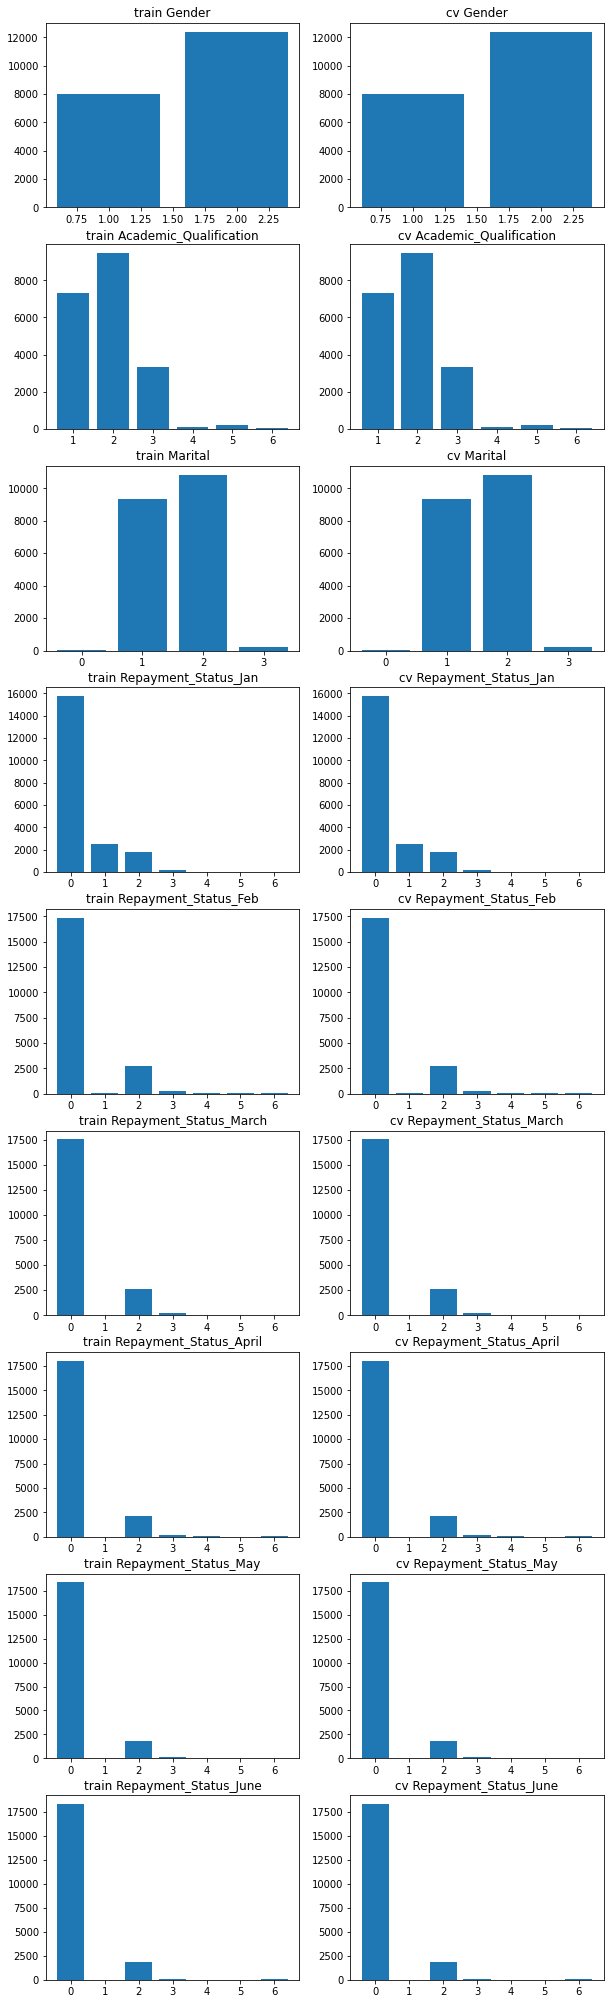

In [12]:
plot_bar(x_train,cat_cols)

The distribution of the data across the categories for all the categorical variables is almost same in train and cross validation set

# Categorical Column Bivariate Analysis

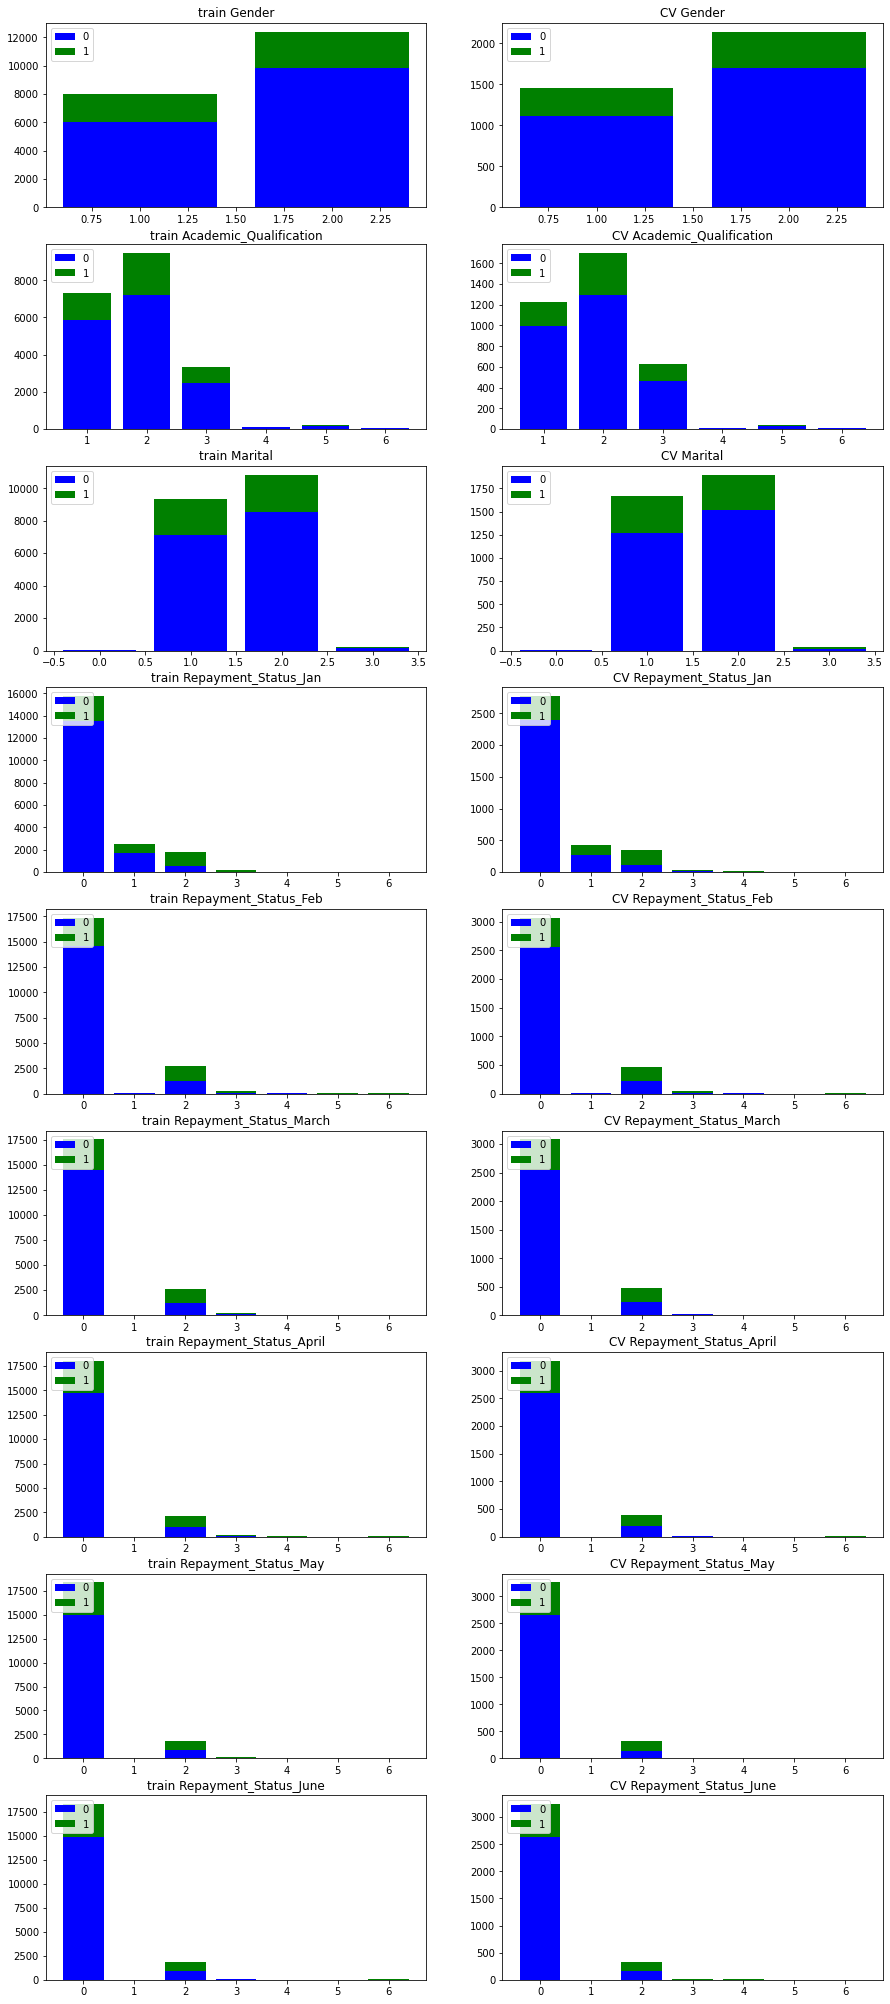

In [13]:
plot_stack(x_train,cat_cols,y_train,x_cv,y_cv)

The distribution of data across train and cross validation is almost same.

In [14]:
cat_3_cols=get_cols_cat_more3(x_train,cat_cols)

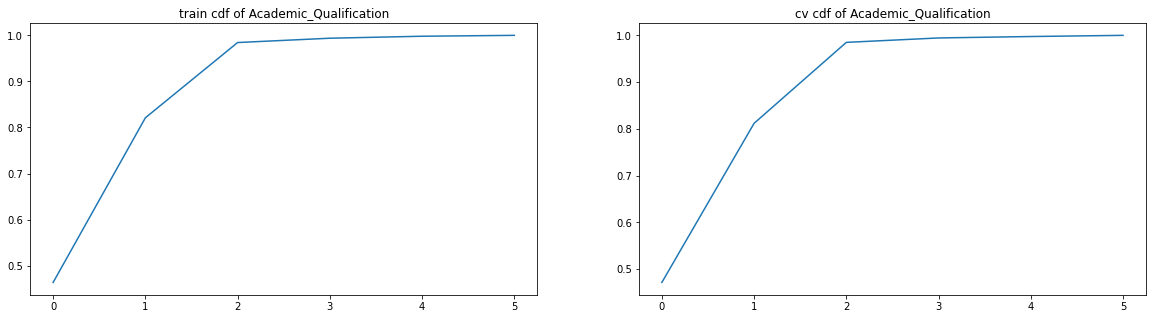

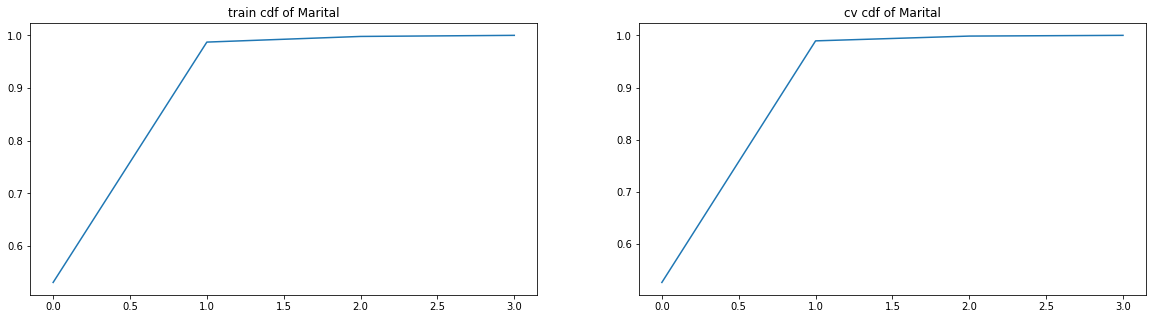

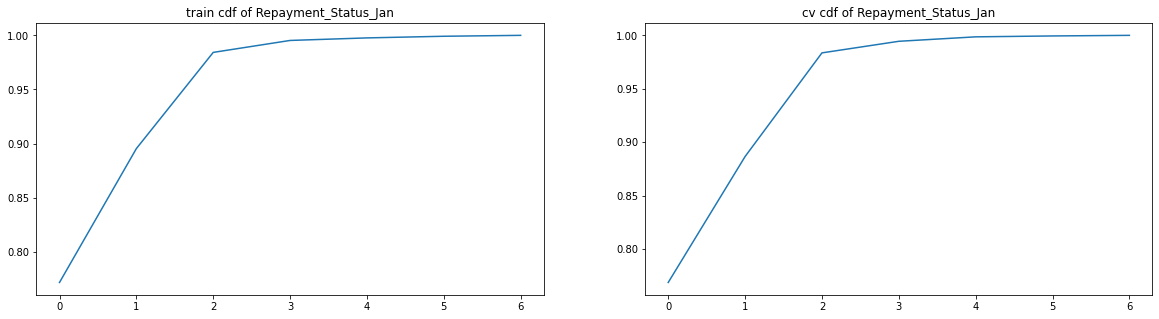

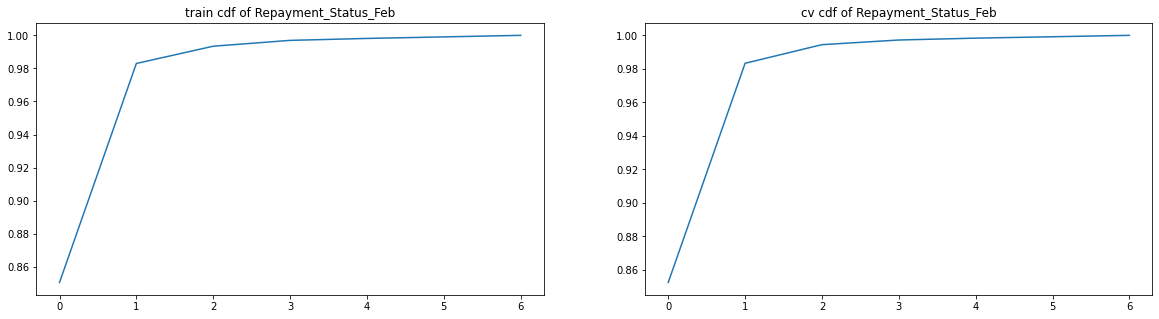

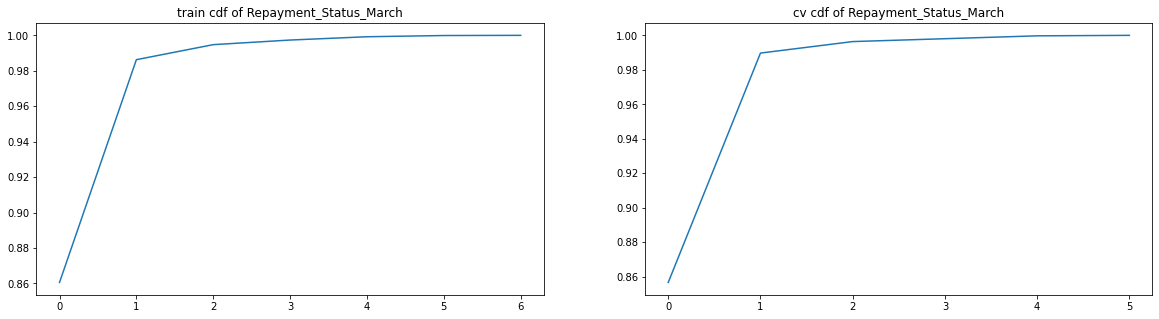

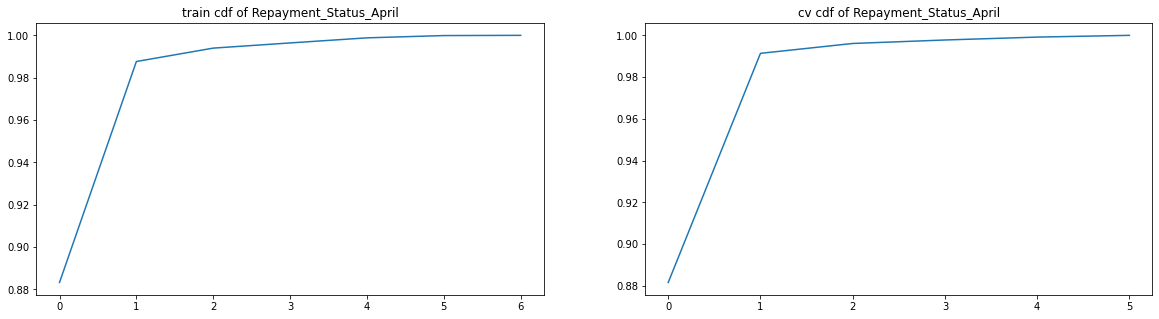

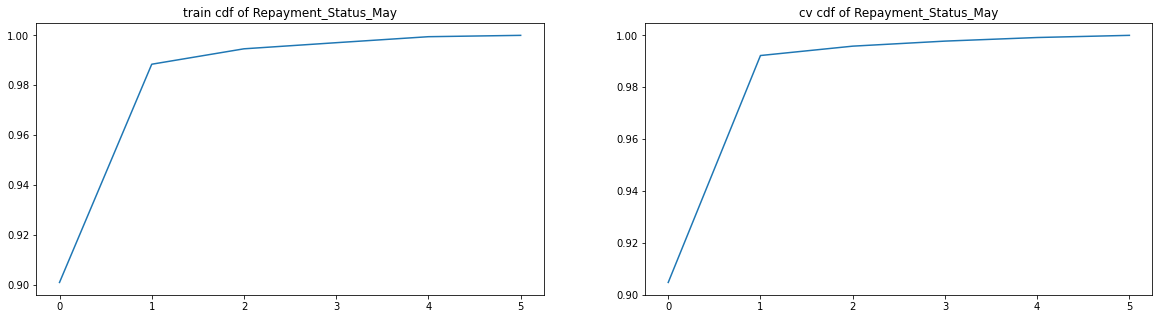

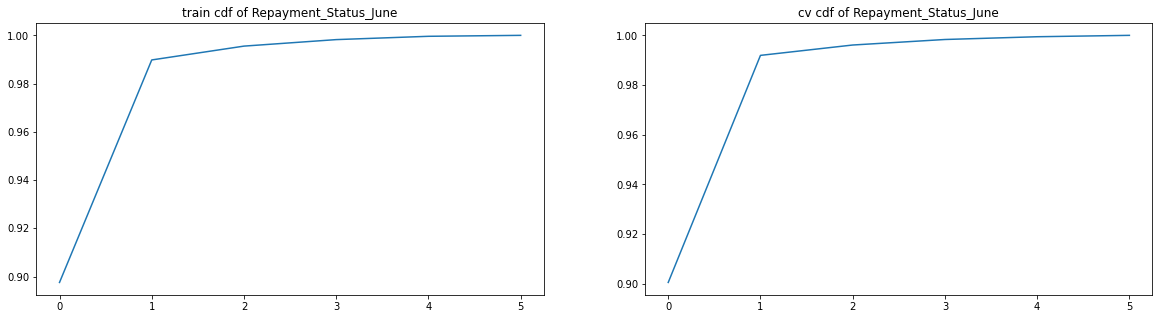

In [15]:
plot_cat_cum_dist(x_train,cat_3_cols,x_cv)

Even the cumulative distribution of the categories are same across train and cross validation set

# Outlier Analysis

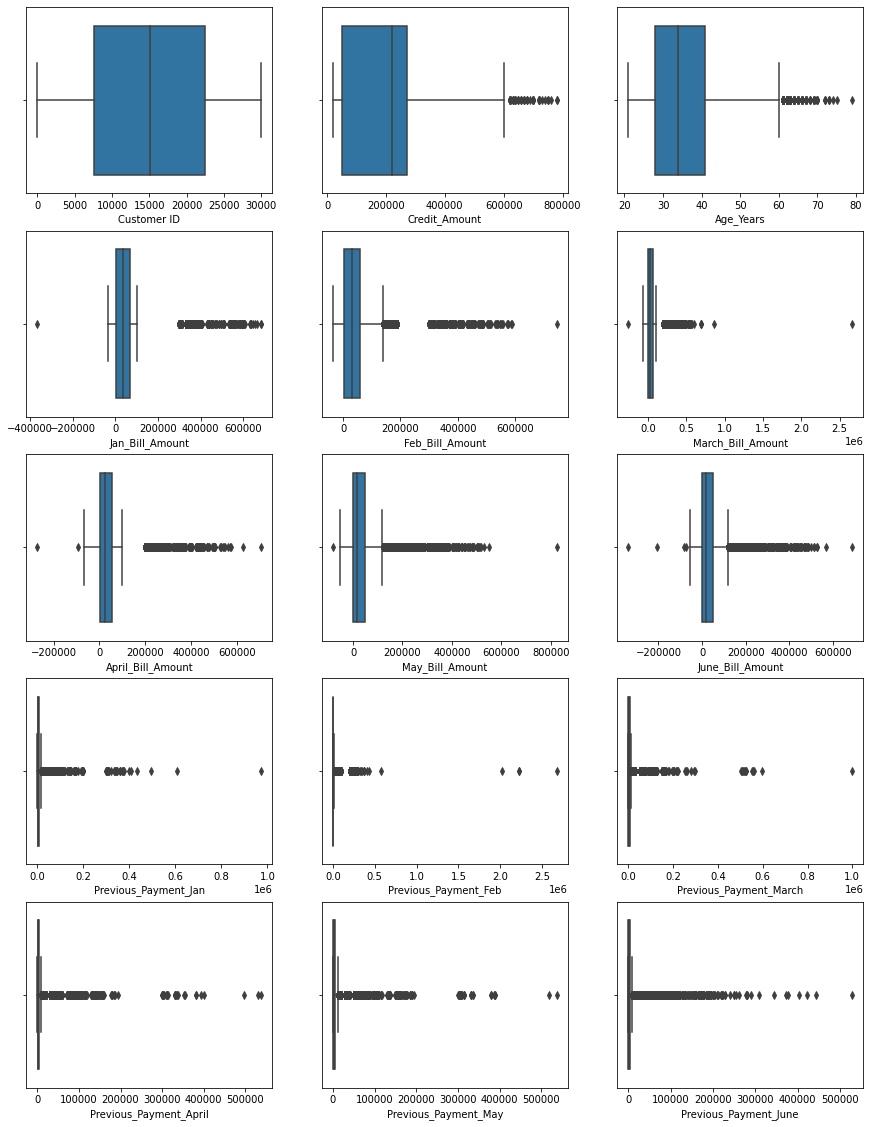

In [16]:
plot_box_num(x_train,num_cols)

In [17]:
x_train_p,bound_val=rm_outliers(x_train.copy(),num_cols[1:])

In [18]:
def rm_outliers_other(df,col_list,bounds):
    for i in col_list:
        df.loc[df[i]>bounds[i][1],i]=bounds[i][1]
        df.loc[df[i]<bounds[i][0],i]=bounds[i][0]
    return df

In [19]:
x_test_p=rm_outliers_other(x_test.copy(),num_cols[1:],bound_val)
x_cv_p=rm_outliers_other(x_cv.copy(),num_cols[1:],bound_val)

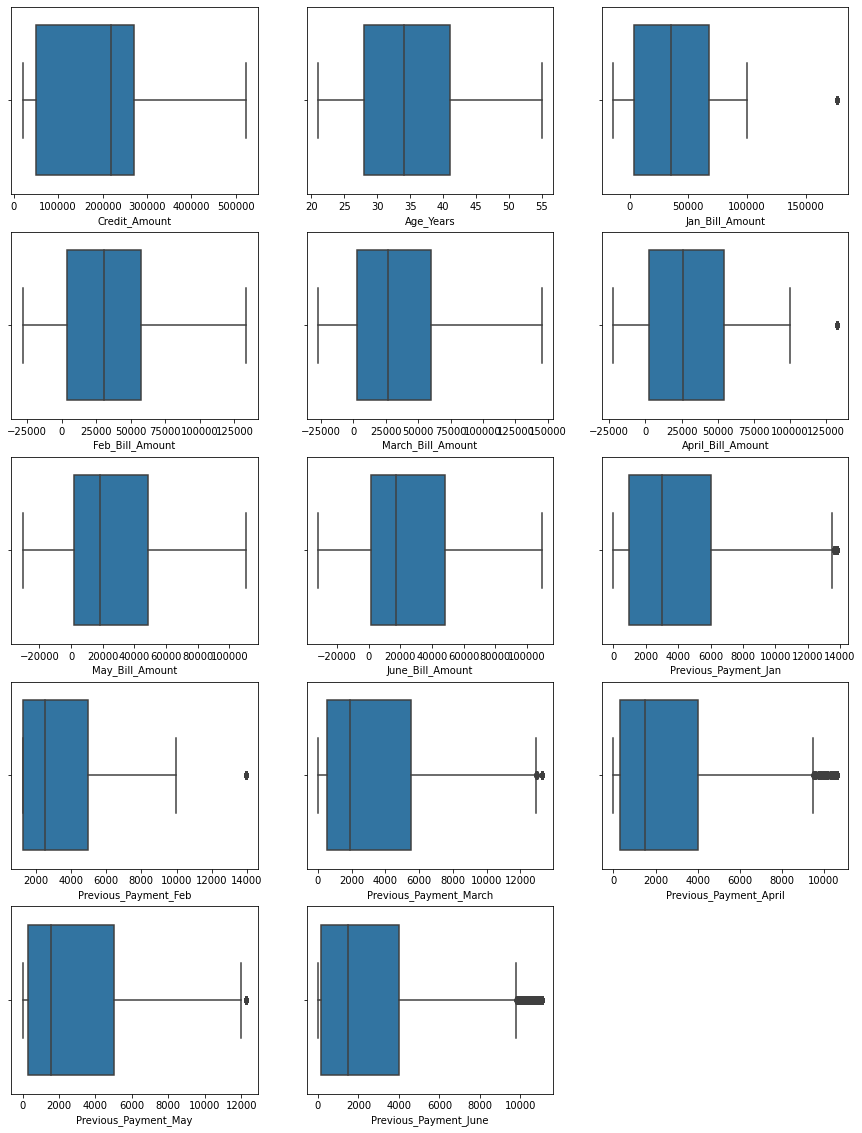

In [20]:
plot_box_num(x_train_p,num_cols[1:])

# Bivariate Analysis of numeric variables

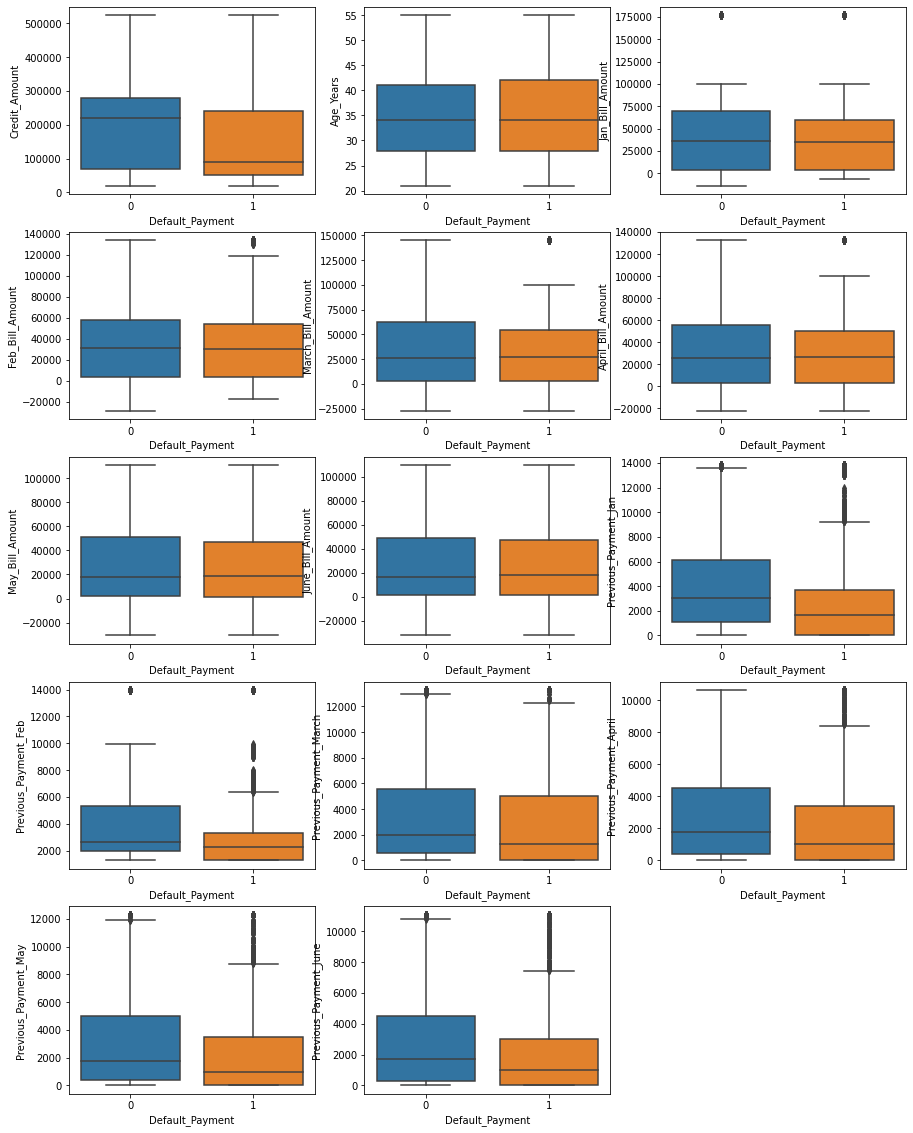

In [21]:
plot_box_num(x_train_p,num_cols[1:],y_train,flag=True)

The bill payment columns are not useful much it seems from the plot

<AxesSubplot:>

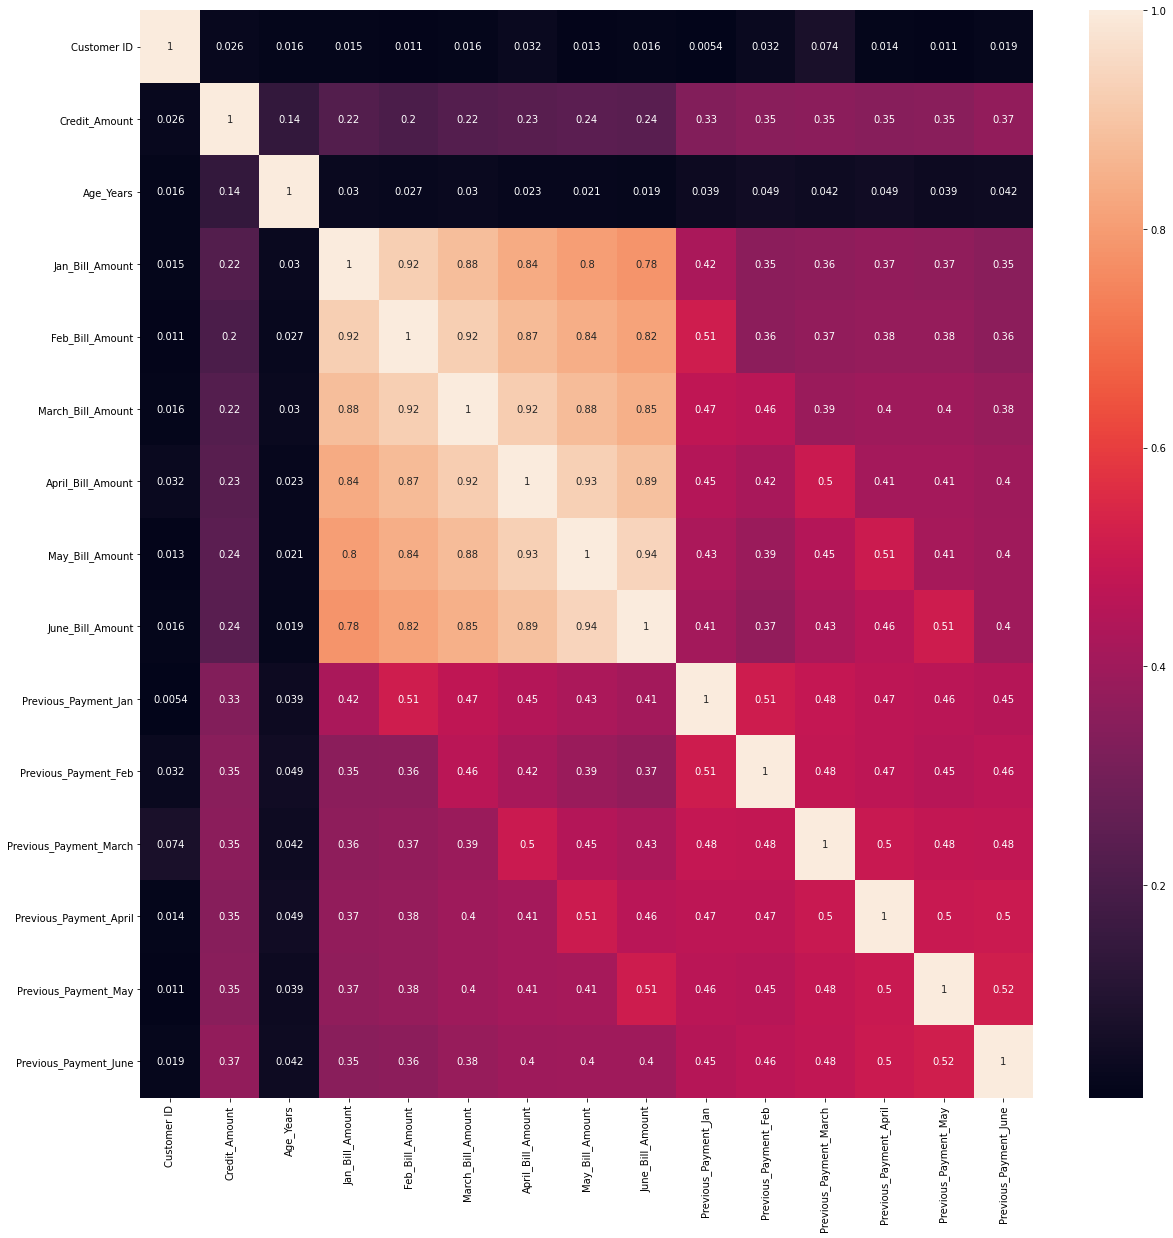

In [22]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
corr_data=x_train_p.corr()
sns.heatmap(corr_data,annot=True)

The bill amount columns from jan to june are all highly correlated.

We will create a addition of all these columns into one column.

In [23]:
x_train_p["Bill_Amount_Total"]=x_train_p.Jan_Bill_Amount+x_train_p.Feb_Bill_Amount+\
                                x_train_p.March_Bill_Amount+ x_train_p.April_Bill_Amount+x_train_p.May_Bill_Amount+\
                                x_train_p.June_Bill_Amount  

x_test_p["Bill_Amount_Total"]=x_test_p.Jan_Bill_Amount+x_test_p.Feb_Bill_Amount+\
                                x_test_p.March_Bill_Amount+ x_test_p.April_Bill_Amount+x_test_p.May_Bill_Amount+\
                                x_test_p.June_Bill_Amount  

x_cv_p["Bill_Amount_Total"]=x_cv_p.Jan_Bill_Amount+x_cv_p.Feb_Bill_Amount+\
                                x_cv_p.March_Bill_Amount+ x_cv_p.April_Bill_Amount+x_cv_p.May_Bill_Amount+\
                                x_cv_p.June_Bill_Amount 

In [24]:
x_train_p["Bill_Amount_Total"].head(2)

16336    246711.0
4023      24990.0
Name: Bill_Amount_Total, dtype: float64

In [25]:
x_train_p[["Jan_Bill_Amount","Feb_Bill_Amount","March_Bill_Amount","April_Bill_Amount","May_Bill_Amount",
           "June_Bill_Amount"]].head(2)

,Jan_Bill_Amount,Feb_Bill_Amount,March_Bill_Amount,April_Bill_Amount,May_Bill_Amount,June_Bill_Amount
16336,57367.0,57335.0,47343.0,29264.0,27828.0,27574.0
4023,5343.0,3738.0,2360.0,6976.0,3701.0,2872.0


In [26]:
x_train_p.drop(["Jan_Bill_Amount","Feb_Bill_Amount","March_Bill_Amount","April_Bill_Amount","May_Bill_Amount",
           "June_Bill_Amount"],axis=1,inplace=True)

In [27]:
x_cv_p.drop(["Jan_Bill_Amount","Feb_Bill_Amount","March_Bill_Amount","April_Bill_Amount","May_Bill_Amount",
           "June_Bill_Amount"],axis=1,inplace=True)
x_test_p.drop(["Jan_Bill_Amount","Feb_Bill_Amount","March_Bill_Amount","April_Bill_Amount","May_Bill_Amount",
           "June_Bill_Amount"],axis=1,inplace=True)

<AxesSubplot:>

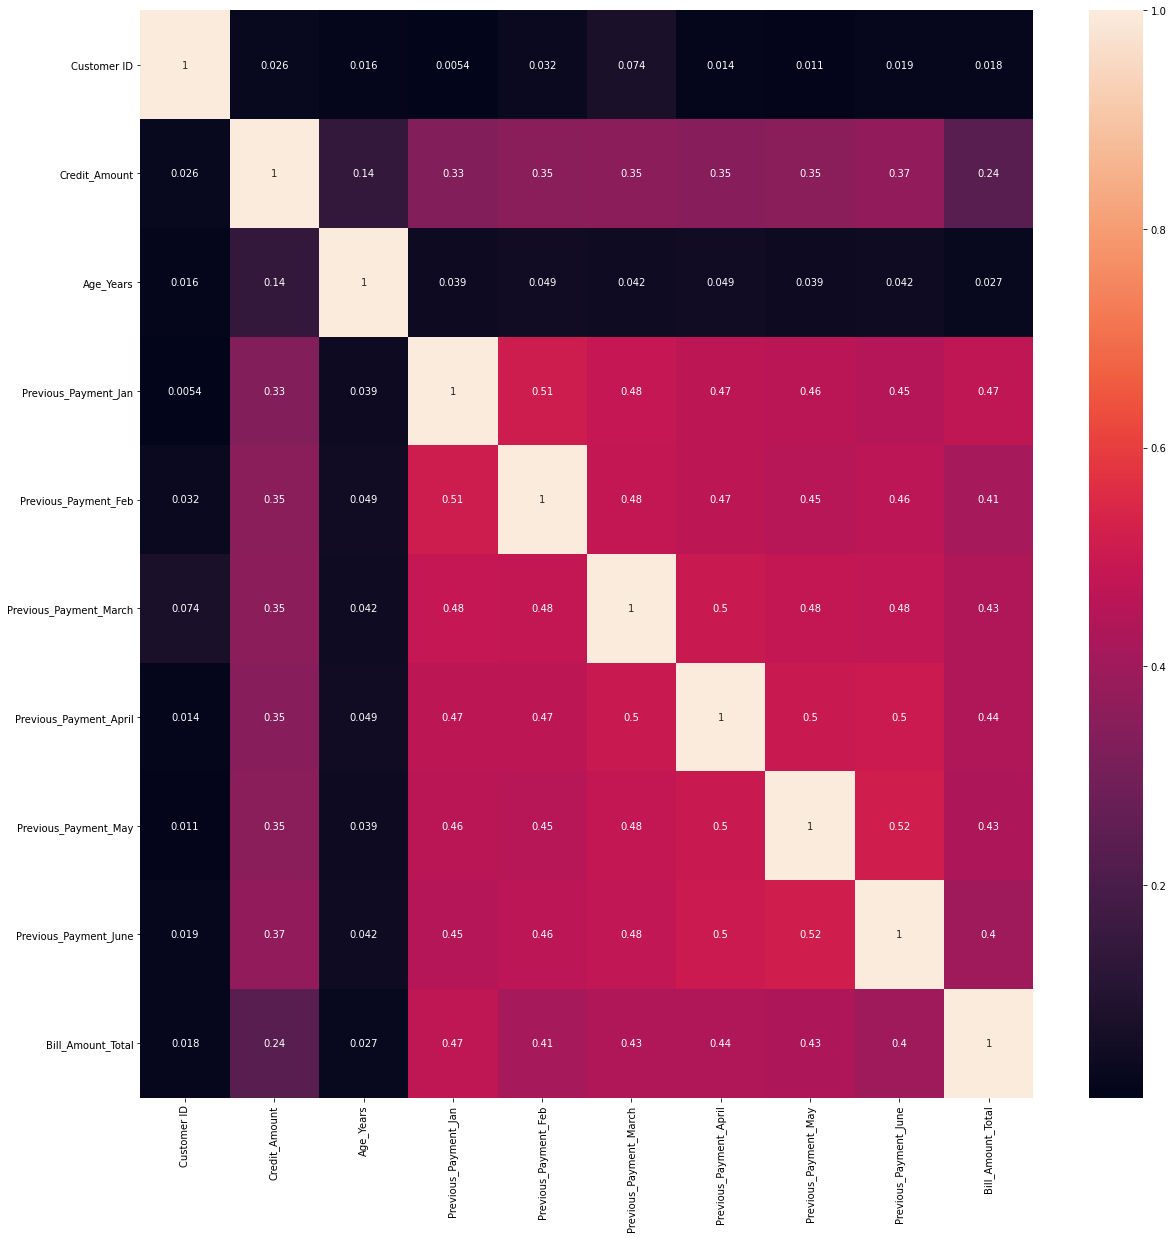

In [28]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
corr_data=x_train_p.corr()
sns.heatmap(corr_data,annot=True)

In [29]:
def get_scaled_data(df,col_list):
    scalers_list=dict({})
    cnt=0
    for i in col_list:
        scaler=MinMaxScaler()
        val=scaler.fit_transform(np.asarray(df[i]).reshape(-1,1)).flatten()
        if cnt==0:
            df_temp=pd.DataFrame({})
        df_temp=pd.concat([df_temp,pd.Series(val)],axis=1)
        scalers_list[i]=scaler
        cnt=1
    return scalers_list,df_temp

In [31]:
num_cols,cat_cols=get_num_cat_cols_list(x_train_p)
scalers,train=get_scaled_data(x_train_p,num_cols)
print(train.shape)

(20400, 10)


In [32]:
def get_scaled_other_data(df,col_list,scaler_dict):
    
    df_temp=pd.DataFrame({})
    for i in col_list:
        scaler=scaler_dict[i]
        val=scaler.transform(np.asarray(df[i]).reshape(-1,1)).flatten()
            
        df_temp=pd.concat([df_temp,pd.Series(val)],axis=1)
    return df_temp
cv=get_scaled_other_data(x_cv_p,num_cols,scalers)
test=get_scaled_other_data(x_test_p,num_cols,scalers)

In [33]:
#Response encoding : 
def response_encoder(col,tgt_col,indices):
    counter=0
    uniq_val=col.unique()
    dictionary=({})
    for i in uniq_val:
        dictionary[i]=[0,0]
    for i,val in enumerate(col):
        ind=indices[i]
        if tgt_col[ind]==0:
            dictionary[val][0]=dictionary[val][0]+1
        else:
            dictionary[val][1]=dictionary[val][1]+1    
    values=[]
    ones_values=[]
    zeros_values=[]
    for i ,val in enumerate(col):
        ones_values.append(dictionary[val][1]/(dictionary[val][0]+dictionary[val][1]))
        zeros_values.append(dictionary[val][0]/(dictionary[val][0]+dictionary[val][1]))
    return pd.Series(ones_values),pd.Series(zeros_values),dictionary       

In [34]:
gender_rc_ones,gender_rc_zeros,gender_dict=response_encoder(x_train_p["Gender"],y_train,indices_train)
aq_rc_ones,aq_rc_zeors,ac_dict=response_encoder(x_train_p["Academic_Qualification"],y_train,indices_train)
marital_rc_ones,marital_rc_zeros,marital_dict=response_encoder(x_train_p["Marital"],y_train,indices_train)
rsj_rc_1,rsj_rc_0,rsj_dict=response_encoder(x_train_p["Repayment_Status_Jan"],y_train,indices_train)
rsf_rc_1,rsf_rc_0,rsf_dict=response_encoder(x_train_p["Repayment_Status_Feb"],y_train,indices_train)
rsmarch_rc_1,rsmarch_rc_0,rsmarch_dict=response_encoder(x_train_p["Repayment_Status_March"],y_train,indices_train)
rsa_rc_1,rsa_rc_0,rsa_dict=response_encoder(x_train_p["Repayment_Status_April"],y_train,indices_train)
rsm_rc_1,rsm_rc_0,rsm_dict=response_encoder(x_train_p["Repayment_Status_May"],y_train,indices_train)
rsjune_rc_1,rsjune_rc_0,rsjune_dict=response_encoder(x_train_p["Repayment_Status_June"],y_train,indices_train)

In [35]:
num_cols,cat_cols=get_num_cat_cols_list(x_train_p)
x_train_p_set2=pd.concat([train,gender_rc_ones,gender_rc_zeros,
                         aq_rc_ones,aq_rc_zeors,marital_rc_ones,marital_rc_zeros,
                         rsj_rc_1,rsj_rc_0,rsf_rc_1,rsf_rc_0,rsmarch_rc_1,rsmarch_rc_0,
                         rsa_rc_1,rsa_rc_0,rsm_rc_1,rsm_rc_0,rsjune_rc_1,rsjune_rc_0],axis=1).copy()

In [36]:
def get_response_encoded_other(col,dictionary):
    ones_values=[]
    zeros_values=[]
    for i ,val in enumerate(col):
        ones_values.append(dictionary[val][1]/(dictionary[val][0]+dictionary[val][1]))
        zeros_values.append(dictionary[val][0]/(dictionary[val][0]+dictionary[val][1]))
    return pd.Series(ones_values),pd.Series(zeros_values)

In [37]:
gender_rc_ones,gender_rc_zeros=get_response_encoded_other(x_cv_p["Gender"],gender_dict)
aq_rc_ones,aq_rc_zeors=get_response_encoded_other(x_cv_p["Academic_Qualification"],ac_dict)
marital_rc_ones,marital_rc_zeros=get_response_encoded_other(x_cv_p["Marital"],marital_dict)
rsj_rc_1,rsj_rc_0=get_response_encoded_other(x_cv_p["Repayment_Status_Jan"],rsj_dict)
rsf_rc_1,rsf_rc_0=get_response_encoded_other(x_cv_p["Repayment_Status_Feb"],rsf_dict)
rsmarch_rc_1,rsmarch_rc_0=get_response_encoded_other(x_cv_p["Repayment_Status_March"],rsmarch_dict)
rsa_rc_1,rsa_rc_0=get_response_encoded_other(x_cv_p["Repayment_Status_April"],rsa_dict)
rsm_rc_1,rsm_rc_0=get_response_encoded_other(x_cv_p["Repayment_Status_May"],rsm_dict)
rsjune_rc_1,rsjune_rc_0=get_response_encoded_other(x_cv_p["Repayment_Status_June"],rsjune_dict)

In [38]:
x_cv_p_set2=pd.concat([cv,gender_rc_ones,gender_rc_zeros,
                         aq_rc_ones,aq_rc_zeors,marital_rc_ones,marital_rc_zeros,
                         rsj_rc_1,rsj_rc_0,rsf_rc_1,rsf_rc_0,rsmarch_rc_1,rsmarch_rc_0,
                         rsa_rc_1,rsa_rc_0,rsm_rc_1,rsm_rc_0,rsjune_rc_1,rsjune_rc_0],axis=1).copy()

In [39]:
gender_rc_ones,gender_rc_zeros=get_response_encoded_other(x_test_p["Gender"],gender_dict)
aq_rc_ones,aq_rc_zeors=get_response_encoded_other(x_test_p["Academic_Qualification"],ac_dict)
marital_rc_ones,marital_rc_zeros=get_response_encoded_other(x_test_p["Marital"],marital_dict)
rsj_rc_1,rsj_rc_0=get_response_encoded_other(x_test_p["Repayment_Status_Jan"],rsj_dict)
rsf_rc_1,rsf_rc_0=get_response_encoded_other(x_test_p["Repayment_Status_Feb"],rsf_dict)
rsmarch_rc_1,rsmarch_rc_0=get_response_encoded_other(x_test_p["Repayment_Status_March"],rsmarch_dict)
rsa_rc_1,rsa_rc_0=get_response_encoded_other(x_test_p["Repayment_Status_April"],rsa_dict)
rsm_rc_1,rsm_rc_0=get_response_encoded_other(x_test_p["Repayment_Status_May"],rsm_dict)
rsjune_rc_1,rsjune_rc_0=get_response_encoded_other(x_test_p["Repayment_Status_June"],rsjune_dict)

x_test_p_set2=pd.concat([test,gender_rc_ones,gender_rc_zeros,
                         aq_rc_ones,aq_rc_zeors,marital_rc_ones,marital_rc_zeros,
                         rsj_rc_1,rsj_rc_0,rsf_rc_1,rsf_rc_0,rsmarch_rc_1,rsmarch_rc_0,
                         rsa_rc_1,rsa_rc_0,rsm_rc_1,rsm_rc_0,rsjune_rc_1,rsjune_rc_0],axis=1).copy()

In [40]:
from scipy.sparse import hstack
def get_ohe_data(df,col_list):
    mat=np.array([])
    ohe_list=dict({})
    cnt=0
    for i in col_list:
        ohe=OneHotEncoder()
        ohe_arr=ohe.fit_transform(np.asarray(df[i]).reshape(-1,1))
        if cnt==0:
            arr=ohe_arr
        else:
            arr=hstack((arr,ohe_arr))
        ohe_list[i]=ohe
        cnt=cnt+1
    return ohe_list,arr

In [41]:
ohe_list,ohe_arr=get_ohe_data(x_train_p,cat_cols)

In [42]:
ohe_arr.shape

(20400, 52)

In [43]:
def get_ohe_other_data(df,col_list,ohe_dict):
    cnt=0
    for i in col_list:
        ohe=ohe_dict[i]
        ohe_arr=ohe.transform(np.asarray(df[i]).reshape(-1,1))
        if cnt==0:
            arr=ohe_arr
        else:
            arr=hstack((arr,ohe_arr))
        cnt=1
    return arr

In [44]:
ohe_cv=get_ohe_other_data(x_cv_p,cat_cols,ohe_list)
ohe_test=get_ohe_other_data(x_test_p,cat_cols,ohe_list)

In [45]:
x_train_set_3=hstack((np.asarray(train.values),ohe_arr))
x_test_set_3=hstack((np.asarray(test.values),ohe_test))
x_cv_set_3=hstack((np.asarray(cv.values),ohe_cv))

print(x_train_set_3.shape,x_test_set_3.shape,x_cv_set_3.shape)

(20400, 62) (6000, 62) (3600, 62)


In [46]:
y_train=y_train.astype("category")

In [47]:
y_cv=y_cv.astype("category")
y_test=y_test.astype("category")

In [48]:
y_train.value_counts()

0    15887
1     4513
Name: Default_Payment, dtype: int64

# Build Model and evaluate performance

We will use below models for our model buidling task.

1. Logistic Regression
2. Decision Trees
3. Random Forst Classifier
4. Adaboost Classifier

We will use both datasets (ohe, response encoded) for the above models and later compare the performance of each.


In [53]:
import warnings
warnings.filterwarnings("ignore")
clf=LogisticRegression(random_state=100)
clf.fit(x_train_p_set2,y_train)
y_pred_lg_1=clf.predict(x_cv_p_set2)

acc_lg_1=round(accuracy_score(y_cv,y_pred_lg_1),2)
f1_lg_1=round(f1_score(y_cv,y_pred_lg_1),2)

print("Logistic Regresion with Response Encoding :")
print("Accuracy: ",acc_lg_1)
print("F1 Score: ",f1_lg_1)

Logistic Regresion with Response Encoding :
Accuracy:  0.82
F1 Score:  0.47


In [54]:
clf=LogisticRegression(random_state=100)
clf.fit(x_train_set_3,y_train)
y_pred_lg_2=clf.predict(x_cv_set_3)

acc_lg_2=round(accuracy_score(y_cv,y_pred_lg_2),2)
f1_lg_2=round(f1_score(y_cv,y_pred_lg_2),2)

print("Logistic Regresion with One Hot Encoding :")
print("Accuracy: ",acc_lg_2)
print("F1 Score: ",f1_lg_2)

Logistic Regresion with One Hot Encoding :
Accuracy:  0.82
F1 Score:  0.46


In [55]:
clf=DecisionTreeClassifier(random_state=100)
clf.fit(x_train_p_set2,y_train)
y_pred_dt_1=clf.predict(x_cv_p_set2)

acc_dt_1=round(accuracy_score(y_cv,y_pred_dt_1),2)
f1_dt_1=round(f1_score(y_cv,y_pred_dt_1),2)

print("Decision Tree with Response Encoding :")
print("Accuracy: ",acc_dt_1)
print("F1 Score: ",f1_dt_1)

Decision Tree with Response Encoding :
Accuracy:  0.73
F1 Score:  0.42


In [56]:
clf=DecisionTreeClassifier(random_state=100)
clf.fit(x_train_set_3,y_train)
y_pred_dt_2=clf.predict(x_cv_set_3)

acc_dt_2=round(accuracy_score(y_cv,y_pred_dt_2),2)
f1_dt_2=round(f1_score(y_cv,y_pred_dt_2),2)

print("Decision Tree with One Hot Encoding :")
print("Accuracy: ",acc_dt_2)
print("F1 Score: ",f1_dt_2)

Decision Tree with One Hot Encoding :
Accuracy:  0.72
F1 Score:  0.4


In [57]:
clf=RandomForestClassifier( n_estimators= 200,random_state=100)
clf.fit(x_train_p_set2,y_train)
y_pred_rf_1=clf.predict(x_cv_p_set2)

acc_rf_1=round(accuracy_score(y_cv,y_pred_rf_1),2)
f1_rf_1=round(f1_score(y_cv,y_pred_rf_1),2)

print("Random Forest Classifier with Response Encoding :")
print("Accuracy: ",acc_rf_1)
print("F1 Score: ",f1_rf_1)

Random Forest Classifier with Response Encoding :
Accuracy:  0.82
F1 Score:  0.5


In [58]:
clf=RandomForestClassifier(n_estimators= 200,random_state=100)
clf.fit(x_train_p_set2,y_train)
y_pred_rf_2=clf.predict(x_cv_p_set2)

acc_rf_2=round(accuracy_score(y_cv,y_pred_rf_2),2)
f1_rf_2=round(f1_score(y_cv,y_pred_rf_2),2)

print("Random Forest Classifier with One Hot Encoding :")
print("Accuracy: ",acc_rf_2)
print("F1 Score: ",f1_rf_2)

Random Forest Classifier with One Hot Encoding :
Accuracy:  0.82
F1 Score:  0.5


In [59]:
clf=AdaBoostClassifier( n_estimators= 200,random_state=100)
clf.fit(x_train_p_set2,y_train)
y_pred_ab_1=clf.predict(x_cv_p_set2)

acc_ab_1=round(accuracy_score(y_cv,y_pred_ab_1),2)
f1_ab_1=round(f1_score(y_cv,y_pred_ab_1),2)

print("Adaboost Classifier with Response Encoding :")
print("Accuracy: ",acc_ab_1)
print("F1 Score: ",f1_ab_1)

Adaboost Classifier with Response Encoding :
Accuracy:  0.82
F1 Score:  0.45


In [60]:
clf=AdaBoostClassifier( n_estimators= 200,random_state=100)
clf.fit(x_train_set_3,y_train)
y_pred_ab_2=clf.predict(x_cv_set_3)

acc_ab_2=round(accuracy_score(y_cv,y_pred_ab_2),2)
f1_ab_2=round(f1_score(y_cv,y_pred_ab_2),2)

print("Adaboost Classifier with One Hot Encoding :")
print("Accuracy: ",acc_ab_2)
print("F1 Score: ",f1_ab_2)

Adaboost Classifier with One Hot Encoding :
Accuracy:  0.82
F1 Score:  0.45


In [61]:
#!pip install imblearn
import imblearn
oversample = SMOTE()
x_train_set_2=np.asarray(x_train_p_set2.values)
x_train_set_2, y_train_2 = oversample.fit_resample(x_train_set_2, y_train)
x_train_set_3_1,y_train_3=oversample.fit_resample(x_train_set_3,y_train)

In [62]:
print(y_train_2.value_counts())
print(y_train_3.value_counts())

0    15887
1    15887
Name: Default_Payment, dtype: int64
0    15887
1    15887
Name: Default_Payment, dtype: int64


In [63]:
clf=LogisticRegression()
clf.fit(x_train_set_2,y_train_2)
x_cv_set_2=np.asarray(x_cv_p_set2)
y_pred_lg_os_1=clf.predict(x_cv_set_2)

acc_lgos_1=round(accuracy_score(y_cv,y_pred_lg_os_1),2)
f1_lgos_1=round(f1_score(y_cv,y_pred_lg_os_1),2)


print("Logistic Regression with Response Encoding :")
print("Accuracy: ",acc_lgos_1)
print("F1 Score: ",f1_lgos_1)

Logistic Regression with Response Encoding :
Accuracy:  0.79
F1 Score:  0.56


In [64]:
clf=LogisticRegression()
clf.fit(x_train_set_3_1,y_train_2)
y_pred_lgos_2=clf.predict(x_cv_set_3)

acc_lgos_2=round(accuracy_score(y_cv,y_pred_lgos_2),2)
f1_lgos_2=round(f1_score(y_cv,y_pred_lgos_2),2)


print("Logistic Regression with One Hot Encoding :")
print("Accuracy: ",acc_lgos_2)
print("F1 Score: ",f1_lgos_2)

Logistic Regression with One Hot Encoding :
Accuracy:  0.78
F1 Score:  0.55


In [65]:
clf=DecisionTreeClassifier()
clf.fit(x_train_set_2,y_train_2)
x_cv_set_2=np.asarray(x_cv_p_set2)
y_pred_dt_os_1=clf.predict(x_cv_set_2)

acc_dtos_1=round(accuracy_score(y_cv,y_pred_dt_os_1),2)
f1_dtos_1=round(f1_score(y_cv,y_pred_dt_os_1),2)


print("Decision Tree Classifier with Response Encoding :")
print("Accuracy: ",acc_dtos_1)
print("F1 Score: ",f1_dtos_1)

Decision Tree Classifier with Response Encoding :
Accuracy:  0.72
F1 Score:  0.4


In [66]:
clf=DecisionTreeClassifier()
clf.fit(x_train_set_3_1,y_train_2)
y_pred_dtos_2=clf.predict(x_cv_set_3)

acc_dtos_2=round(accuracy_score(y_cv,y_pred_dtos_2),2)
f1_dtos_2=round(f1_score(y_cv,y_pred_dtos_2),2)


print("Decision Tree  with One Hot Encoding :")
print("Accuracy: ",acc_dtos_2)
print("F1 Score: ",f1_dtos_2)

Decision Tree  with One Hot Encoding :
Accuracy:  0.7
F1 Score:  0.4


In [67]:
clf=RandomForestClassifier()
clf.fit(x_train_set_2,y_train_2)
x_cv_set_2=np.asarray(x_cv_p_set2)
y_pred_rf_os_1=clf.predict(x_cv_set_2)

acc_rfos_1=round(accuracy_score(y_cv,y_pred_rf_os_1),2)
f1_rfos_1=round(f1_score(y_cv,y_pred_rf_os_1),2)


print("Random Forest Classifier with Response Encoding :")
print("Accuracy: ",acc_rfos_1)
print("F1 Score: ",f1_rfos_1)

clf=RandomForestClassifier()
clf.fit(x_train_set_3_1,y_train_2)
y_pred_rfos_2=clf.predict(x_cv_set_3)

acc_rfos_2=round(accuracy_score(y_cv,y_pred_rfos_2),2)
f1_rfos_2=round(f1_score(y_cv,y_pred_rfos_2),2)


print("Random Forest Classifier  with One Hot Encoding :")
print("Accuracy: ",acc_rfos_2)
print("F1 Score: ",f1_rfos_2)

Random Forest Classifier with Response Encoding :
Accuracy:  0.82
F1 Score:  0.51
Random Forest Classifier  with One Hot Encoding :
Accuracy:  0.81
F1 Score:  0.53


In [68]:
from prettytable import PrettyTable

tbl=PrettyTable(["Classifier","Response Encoding(acc,f1score)","One hot Encoding(acc,f1score)"])

tbl.add_row(["Logistic Regression",(acc_lg_1,f1_lg_1),(acc_lg_2,f1_lg_2)])
tbl.add_row(["Decision Tree",(acc_dt_1,f1_dt_1),(acc_dt_2,f1_dt_2)])
tbl.add_row(["Random Forest",(acc_rf_1,f1_rf_1),(acc_rf_2,f1_rf_2)])
tbl.add_row(["Adboost",(acc_ab_1,f1_ab_1),(acc_ab_2,f1_ab_2)])
tbl.add_row(["Logistic with Oversampling",(acc_lgos_1,f1_lgos_1),(acc_lgos_2,f1_lgos_2)])
tbl.add_row(["Decision Tree with Oversampling",(acc_dtos_1,f1_dtos_1),(acc_dtos_2,f1_dtos_2)])
tbl.add_row(["RandomForest with Oversampling",(acc_rfos_1,f1_rfos_1),(acc_rfos_2,f1_rfos_2)])
print(tbl)

+---------------------------------+--------------------------------+-------------------------------+
|            Classifier           | Response Encoding(acc,f1score) | One hot Encoding(acc,f1score) |
+---------------------------------+--------------------------------+-------------------------------+
|       Logistic Regression       |          (0.82, 0.47)          |          (0.82, 0.46)         |
|          Decision Tree          |          (0.73, 0.42)          |          (0.72, 0.4)          |
|          Random Forest          |          (0.82, 0.5)           |          (0.82, 0.5)          |
|             Adboost             |          (0.82, 0.45)          |          (0.82, 0.45)         |
|    Logistic with Oversampling   |          (0.79, 0.56)          |          (0.78, 0.55)         |
| Decision Tree with Oversampling |          (0.72, 0.4)           |           (0.7, 0.4)          |
|  RandomForest with Oversampling |          (0.82, 0.51)          |          (0.81, 0.53) 

In [69]:
logreg_params=({"penalty":["l1","l2"],
               "C":[0.003,0.03,0.3,1,3,10]})
clf=LogisticRegression(random_state=100)
grid_clf_logreg=GridSearchCV(clf,logreg_params,cv=2,scoring="f1")
grid_clf_logreg.fit(x_train_set_3_1,y_train_2)
grid_clf_logreg.best_params_

{'C': 0.003, 'penalty': 'l2'}

In [70]:
clf=LogisticRegression(C=0.003)
clf.fit(x_train_set_3_1,y_train_2)

y_pred_lgos_2=clf.predict(x_train_set_3_1)

acc_lgos_cv=round(accuracy_score(y_train_2,y_pred_lgos_2),2)
f1_lgos_cv=round(f1_score(y_train_2,y_pred_lgos_2),2)


print("Logistic Regression with One Hot Encoding on Train dataset:")
print("Accuracy: ",acc_lgos_cv)
print("F1 Score: ",f1_lgos_cv)


y_pred_lgos_2=clf.predict(x_cv_set_3)

acc_lgos_cv=round(accuracy_score(y_cv,y_pred_lgos_2),2)
f1_lgos_cv=round(f1_score(y_cv,y_pred_lgos_2),2)


print("Logistic Regression with One Hot Encoding on CV dataset:")
print("Accuracy: ",acc_lgos_cv)
print("F1 Score: ",f1_lgos_cv)


y_pred_lgos_2=clf.predict(x_test_set_3)

acc_lgos_test=round(accuracy_score(y_test,y_pred_lgos_2),2)
f1_lgos_test=round(f1_score(y_test,y_pred_lgos_2),2)


print("Logistic Regression with One Hot Encoding on test dataset:")
print("Accuracy: ",acc_lgos_test)
print("F1 Score: ",f1_lgos_test)



Logistic Regression with One Hot Encoding on Train dataset:
Accuracy:  0.7
F1 Score:  0.66
Logistic Regression with One Hot Encoding on CV dataset:
Accuracy:  0.79
F1 Score:  0.56
Logistic Regression with One Hot Encoding on test dataset:
Accuracy:  0.79
F1 Score:  0.55


## Hence Logistic Regression with One hot encoding and oversampling gave better performance from all the models selected for the task at hand.